In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Load and Prepare Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('validation.csv')


In [5]:
# Encode labels ('ham' -> 0, 'spam' -> 1)
X_train, y_train = train['sms'], train['label'].map({'ham': 0, 'spam': 1})
X_test, y_test = test['sms'], test['label'].map({'ham': 0, 'spam': 1})
X_valid, y_valid = valid['sms'], valid['label'].map({'ham': 0, 'spam': 1})

# Remove missing values
for X, y in [(X_train, y_train), (X_valid, y_valid), (X_test, y_test)]:
    X.dropna(inplace=True)
    y.dropna(inplace=True)


In [6]:
# Convert labels to float
y_train, y_valid, y_test = y_train.astype('float64'), y_valid.astype('float64'), y_test.astype('float64')

# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

# Set up MLflow Experiment
mlflow.set_experiment("SMS Spam Classification with Hyperparameter Tuning")


2025/03/05 00:57:25 INFO mlflow.tracking.fluent: Experiment with name 'SMS Spam Classification with Hyperparameter Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/himanshu/Downloads/data/mlruns/411125929183008674', creation_time=1741116445650, experiment_id='411125929183008674', last_update_time=1741116445650, lifecycle_stage='active', name='SMS Spam Classification with Hyperparameter Tuning', tags={}>

In [7]:

# Define Hyperparameter Grids
param_grid_lr = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'min_samples_split': [2, 5]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}


In [8]:
def train_and_log_model(model, param_grid, model_name):
    with mlflow.start_run(run_name=model_name):
        # Hyperparameter tuning
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_tfidf, y_train)
        
        # Get best model & parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_valid_tfidf)
        
        # Evaluate performance
        acc, f1 = accuracy_score(y_valid, y_pred), f1_score(y_valid, y_pred)
        
        # Log parameters & metrics
        mlflow.log_params(best_params)
        mlflow.log_metric("best_cv_score", grid_search.best_score_)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        
        # Confusion Matrix Plot
        plt.figure(figsize=(5, 5))
        sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"{model_name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f"{model_name}_conf_matrix.png")
        
        # Log artifacts
        mlflow.log_artifact(f"{model_name}_conf_matrix.png")
        
        # Model signature & input example
        signature = infer_signature(X_valid_tfidf.toarray(), y_valid[:5])
        mlflow.sklearn.log_model(best_model, model_name, signature=signature, input_example=X_valid_tfidf[:5].toarray())
        
        print(f"✅ {model_name} training complete! Best params: {best_params}")


✅ Logistic Regression training complete! Best params: {'C': 10, 'solver': 'lbfgs'}
✅ Random Forest training complete! Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
✅ Support Vector Machine training complete! Best params: {'C': 10, 'kernel': 'linear'}
Hyperparameter tuning and training complete!


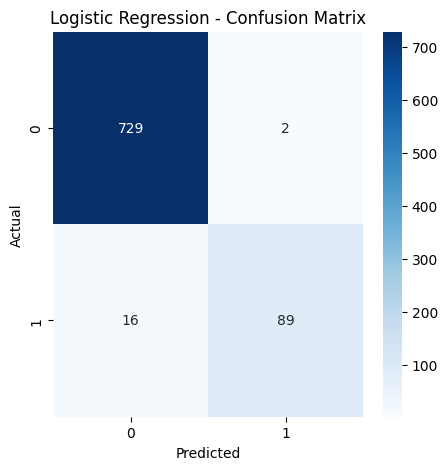

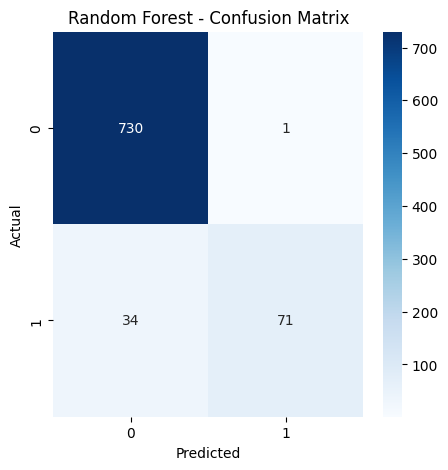

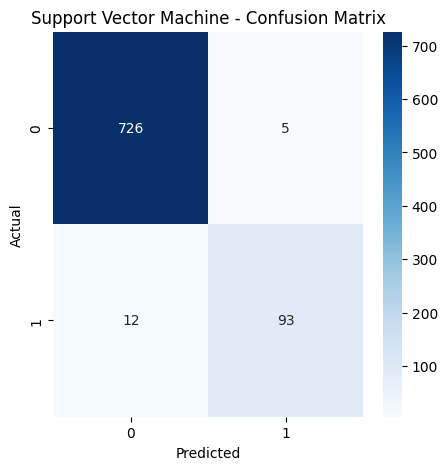

In [9]:
# Train Models
train_and_log_model(LogisticRegression(), param_grid_lr, "Logistic Regression")
train_and_log_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")
train_and_log_model(SVC(), param_grid_svm, "Support Vector Machine")

print("Hyperparameter tuning and training complete!")
